In [8]:
import sys

!{sys.executable} -m pip install numpy scipy h5py matplotlib



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3.12 install --upgrade pip


In [27]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [28]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load all analysis files
# ---------------------------
file_list = sorted(glob.glob("/Users/EllenaLink/Desktop/SLEAP_exports/*analysis.h5"))
print(f"Found {len(file_list)} files")

all_velocities = []

BODY_NODE = 0  # node index representing body center
FPS = 30       # frames per second

for fname in file_list:
    with h5py.File(fname, "r") as f:
        tracks = f["tracks"][:]  # shape: (instances, nodes, coords, frames)

        if tracks.shape[0] == 0:
            print(f"⚠️ No tracked identities in {fname}, skipping identity-based analysis")
            continue

        # Use only x, y coordinates
        xy = tracks[:, BODY_NODE, :2, :]  # (instances, 2, frames)
        xy = np.moveaxis(xy, -1, 1)       # (instances, frames, 2)

        # Compute velocity: Euclidean distance between consecutive frames
        vel = np.linalg.norm(np.diff(xy, axis=1), axis=-1)  # (instances, frames-1)
        all_velocities.append(vel)

if not all_velocities:
    raise RuntimeError("No usable tracks found for velocity analysis.")

# Concatenate velocities across all files
vel_all = np.concatenate(all_velocities, axis=0)

# ------------------------------------
# 2. Plot velocity distribution
# ------------------------------------
plt.figure(figsize=(8,4))
plt.hist(vel_all.flatten(), bins=200, color='skyblue', edgecolor='k')
plt.xlabel("Velocity (px/frame)")
plt.ylabel("Count")
plt.title("Velocity Distribution Across All Detections")
plt.show()

# ------------------------------------
# 3. Darting detection function
# ------------------------------------
def detect_darting(vel, fps=30, percentile=85, min_duration=0.05):
    threshold = np.percentile(vel, percentile)
    dart_mask = vel > threshold

    bouts = []
    in_bout = False
    start = None

    for i, v in enumerate(dart_mask):
        if v and not in_bout:
            in_bout = True
            start = i
        elif not v and in_bout:
            bouts.append((start, i - 1))
            in_bout = False

    if in_bout:
        bouts.append((start, len(dart_mask) - 1))

    durations = [(e - s + 1) / fps for s, e in bouts]
    durations = [d for d in durations if d >= min_duration]

    total_time = sum(durations)
    return bouts, durations, total_time

# ------------------------------------
# 4. Apply darting detection
# ------------------------------------
# Flatten velocities across instances for simplicity
vel_flat = vel_all.flatten()

bouts, durations, total_darting_time = detect_darting(
    vel_flat,
    fps=FPS,
    percentile=85,    # can adjust to make threshold stricter
    min_duration=0.05 # seconds
)

print("Number of darting bouts:", len(durations))
print("Total darting time (sec):", total_darting_time)
print("Bout durations (sec):", durations)


Found 13 files


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 52172 and the array at index 1 has size 28799

In [35]:
all_velocities = []

for fname in file_list:
    with h5py.File(fname, "r") as f:
        tracks = f["tracks"][:].transpose(3, 1, 2, 0)  # (frames, tracks, nodes, xy)
        tracks = fill_missing_tracks(tracks)  # interpolate missing points if needed

        # Compute velocity for body node
        BODY_NODE = 0
        vel = np.linalg.norm(
            np.diff(tracks[:, :, BODY_NODE, :], axis=0),
            axis=-1
        )  # shape: (frames-1, num_tracks)
        all_velocities.append(vel)

# Now all_velocities[i] corresponds to file i
for vel in all_velocities:
    vel_per_rat = [vel[:, i] for i in range(vel.shape[1])]
    plt.hist(vel_per_rat[0], bins=200)
    plt.xlabel("Velocity (px/frame)")
    plt.show()


IndexError: index 1 is out of bounds for axis 3 with size 1

In [29]:
def detect_darting(vel, fps=30, percentile=85, min_duration=0.05):
    threshold = np.percentile(vel, percentile)
    dart_mask = vel > threshold

    bouts = []
    in_bout = False
    start = None

    for i, v in enumerate(dart_mask):
        if v and not in_bout:
            in_bout = True
            start = i
        elif not v and in_bout:
            bouts.append((start, i - 1))
            in_bout = False

    if in_bout:
        bouts.append((start, len(dart_mask) - 1))

    durations = [(e - s + 1) / fps for s, e in bouts]
    durations = [d for d in durations if d >= min_duration]

    return bouts, durations, sum(durations)


In [30]:
BODY_NODE = 0  # torso / center
FPS = 30       # adjust if needed

tracks = tracks_concat

vel = np.linalg.norm(
    np.diff(tracks[:, :, BODY_NODE, :], axis=0),
    axis=-1
)  # (frames-1, animals)

vel_per_rat = [vel[:, i] for i in range(vel.shape[1])]


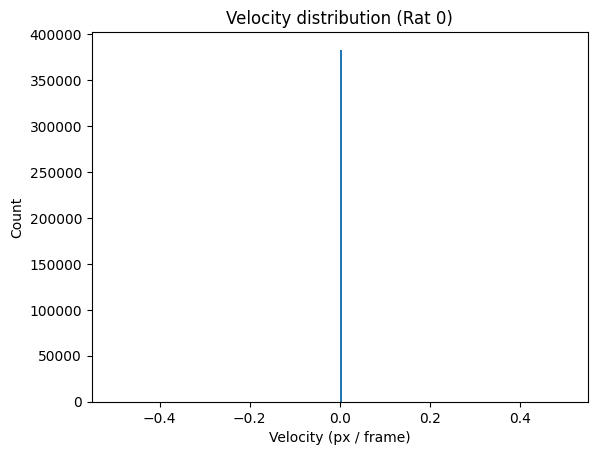

In [31]:
plt.hist(vel_per_rat[0], bins=200)
plt.xlabel("Velocity (px / frame)")
plt.ylabel("Count")
plt.title("Velocity distribution (Rat 0)")
plt.show()


In [32]:
def detect_darting(vel, fps=30, percentile=85, min_duration=0.05):
    threshold = np.percentile(vel, percentile)
    dart_mask = vel > threshold

    bouts = []
    in_bout = False
    start = None

    for i, v in enumerate(dart_mask):
        if v and not in_bout:
            in_bout = True
            start = i
        elif not v and in_bout:
            in_bout = False
            bouts.append((start, i - 1))

    if in_bout:
        bouts.append((start, len(dart_mask) - 1))

    durations = [(e - s + 1) / fps for s, e in bouts]
    durations = [d for d in durations if d >= min_duration]

    total_time = sum(durations)

    return bouts, durations, total_time


In [33]:
for i, vel_i in enumerate(vel_per_rat):
    bouts, durations, total = detect_darting(
        vel_i,
        fps=FPS,
        percentile=85,
        min_duration=0.05
    )

    print(f"Rat {i}")
    print(f"  Bouts: {len(bouts)}")
    print(f"  Total darting time: {total:.2f} sec")
    print(f"  Mean bout duration: {np.mean(durations) if durations else 0:.3f} sec")
    print()


Rat 0
  Bouts: 0
  Total darting time: 0.00 sec
  Mean bout duration: 0.000 sec

Rat 1
  Bouts: 0
  Total darting time: 0.00 sec
  Mean bout duration: 0.000 sec



In [34]:
with h5py.File(file_list[0], "r") as f:
    tracks_raw = f["tracks"]
    print("tracks_raw shape:", tracks_raw.shape)



tracks_raw shape: (2, 2, 4, 52173)
